In [4]:
from pathlib import Path
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from stop_words import get_stop_words

In [5]:
%matplotlib inline

In [6]:
def read_articles_as_df(root):
    root = Path(root)
    articles = []
    for p in root.rglob("*.txt"):
        rel_path = p.relative_to(root)
        tag = rel_path.parts[0]
        with open(p, encoding="utf8") as f:
            articles.append({"category": tag, "text": f.read()})
    return pd.DataFrame(articles)

# Machine Learning

The best, easy explanation of ML I've read: https://hackernoon.com/machine-learning-is-the-emperor-wearing-clothes-59933d12a3cc

## Machine learning using gradient descent

1. Pick a model that can fit or separate your data
2. Select a way to evaluate the fitness of your model - a *loss function*
3. Use the gradients of the loss function to guide you towards the optimal configurations for your model

## Gradient descent for linear regression
$$
y = prediction(x) = \sum_iw_ix_i
$$

<center><img src="images/linreg2.png" style="width: 500px;"/></center>

## The loss function

A common way to evaluate the loss of a model is using the mean squared error (MSE)

$$
MSE = \frac{1}{N} \sum_{(x,y)\in D} (y - prediction(x))^2
$$

<center><img src="images/mse.png" style="width: 700px;"/></center>

## Stepping towards the minimum of the loss function

- We want to improve the model, i.e. reduce the error, by changing the weights given to each variable
- The gradients/partial derivatives of the loss function $J$ with respect to the weights of the model ($\triangledown_{w_i}J$) will tell us the right direction:

$$
w_i \leftarrow w_i - \gamma * \triangledown_{w_i}J
$$

<center><img src="images/gd.png" style="width: 600px;"/></center>

For MSE the derivative will be:

$$
\triangledown_{w_i}J = 2 * \sum_{(x,y) \in D}(prediction(x) - y)*x_i
$$

Which gives:

$$
\begin{align*}
w_i &\leftarrow w_i - \gamma * \triangledown_{w_i}J \\ 
    &= w_i - \gamma * 2 * \sum_{(x,y) \in D}(prediction(x) - y)*x_i \\
    &= w_i - \eta * \sum_{(x,y) \in D}(prediction(x) - y)*x_i
\end{align*}
$$

Intuitively this makes sense:
- prediction close to real value -> only a small change is needed
- e.g. the prediction is too high, and the value if $x_i$ is negative, weight *i* must be increased to get closer to the optimal value

<center><img src="images/linreg.gif" style="width: 1000px;"></center>

## Gradient descent for classification 

- The procesdure is the same, the main difference is the loss function
- One common loss function is *log-loss*. Using this we would get a *logistic regression* model

<center><img src="images/logreg.gif" style="width: 800px;"></center>

# Text Classification

# Step 1: get some data

News from vg.no

In [7]:
df = read_articles_as_df("data/vg_nyheter")

In [8]:
df.text = df.text.str.replace("Her kan du lese mer om$", "", regex=True)

In [9]:
sample = df.sample(frac=1)
sample.head()

,category,text
59,krim,Birgitte Tengs-drapet: Har brukt millionbeløp ...
2114,sjakk,Han tapte tidenes sjakk-duell\nBoris Spasskij ...
4160,vær,«Atmosfærisk elv» av nedbør treffer Vestlandet...
3606,vær,Knallværet i vinterferien fortsetter\nSkientus...
2706,sjakk,Carlsen etter fire uavgjorte: – Dette er ingen...


In [10]:
print(sample.iloc[0].text[:500]+"...")

Birgitte Tengs-drapet: Har brukt millionbeløp på DNA-analyser
Politiet venter DNA-svar i løpet av de første månedene i 2019 og har gjennomgått tusenvis av tips. Noen av dem har ført til nye etterforskningsskritt. 
 Birgitte Tengs (17) ble funnet drept nær hjemmet sitt på Karmøy 6. mai 1995. Hennes fetter ble dømt, så frikjent. Drapet har siden stått uten gjerningsmann. Over 18 år senere etterforskes saken på ny av Sør-Vest politidistrikt, etter at Kripos’ Cold Case-gruppe mente saken hadde «pote...


In [11]:
df.shape

(4179, 2)

## Category distribution

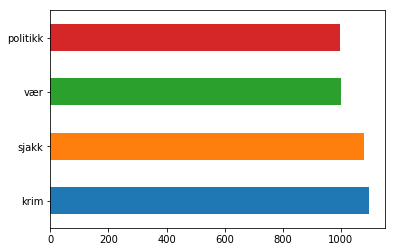

In [12]:
df.category.value_counts().plot.barh();

Percentage of articles with no text

In [13]:
f"{(df.text == '').mean() * 100:.2f}%"

'0.17%'

# Step 2: Convert to numbers

In [30]:
pd.set_option('precision',3)

def get_features_as_df(_X, _vec, n=None):
    if n is None:
        n = _X.shape[0]
    ix = np.asarray((_X[:n].sum(axis=0) > 0)).squeeze() # Select only words being used at least once for the first n rows
    return pd.DataFrame(_X[:n, ix].todense(), columns=np.asarray(_vec.get_feature_names())[ix])

## Turning texts into numbers

Count the time each word occurs in the text, and create one column/feature per word

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

texts = [
    "This sentence has some words",
    "This other sentence has more words",
    "This sentence has the same word twice ha ha"
]
vec = CountVectorizer()
X = vec.fit_transform(texts)
get_features_as_df(X, vec)

,ha,has,more,other,same,sentence,some,the,this,twice,word,words
0,0,1,0,0,0,1,1,0,1,0,0,1
1,0,1,1,1,0,1,0,0,1,0,0,1
2,2,1,0,0,1,1,0,1,1,1,1,0


## Including multi-word terms

In [33]:
vec = CountVectorizer(ngram_range=(1, 2))
X = vec.fit_transform(texts)
get_features_as_df(X, vec)

,ha,ha ha,has,has more,has some,has the,more,more words,other,other sentence,...,the,the same,this,this other,this sentence,twice,twice ha,word,word twice,words
0,0,0,1,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
1,0,0,1,1,0,0,1,1,1,1,...,0,0,1,1,0,0,0,0,0,1
2,2,1,1,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0


## Adding tf-idf weighting

**Tf**: Weigh a word up if it's used multiple times in the same document
**idf**: Weighing down a word by an amount proportional to how often it occurs in other documents

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
X = vec.fit_transform(texts)
get_features_as_df(X, vec)

,ha,has,more,other,same,sentence,some,the,this,twice,word,words
0,0.000,0.365,0.000,0.000,0.000,0.365,0.617,0.000,0.365,0.000,0.000,0.469
1,0.000,0.310,0.525,0.525,0.000,0.310,0.000,0.000,0.310,0.000,0.000,0.399
2,0.665,0.196,0.000,0.000,0.332,0.196,0.000,0.332,0.196,0.332,0.332,0.000


## Removing stopwords

In [40]:
vec = TfidfVectorizer(stop_words="english")
X = vec.fit_transform(texts)
get_features_as_df(X, vec)

,ha,sentence,twice,word,words
0,0.000,0.613,0.000,0.000,0.79
1,0.000,0.613,0.000,0.000,0.79
2,0.794,0.234,0.397,0.397,0.00


## Vectorizing the  VG.no texts

In [ ]:
stopwords = get_stop_words("no")

In [43]:
vec = TfidfVectorizer(min_df=3, max_df=.5, ngram_range=(1, 2), sublinear_tf=True, stop_words=stopwords)
X = vec.fit_transform(df.text)

C:\Users\peter\Anaconda3\envs\osloturen-2019\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [122]:
X.shape

(4179, 25384)

In [123]:
fnames = list(vec.get_feature_names())
len(fnames)

25384

Feature names of 5 random features

In [148]:
shuffle(fnames)
fnames[:5]

['trailer', 'overlege', 'gudmundsen', 'ås', 'foretrekke']

The first five reviews

In [125]:
df.head(5).text

0    Valdres-saken: Moren sendt til sykehus\nGJØVIK...
1    Syv siktet etter gjengkonflikt: Mann skutt i h...
2    Kim Walls kjæreste: Intervjuet ble avtalt samm...
3    Treholt-forfatter med for dårlig tilståelse – ...
4     Mor siktet for omsorgsunndragelse: Pågrepet i...
Name: text, dtype: object

The five first reviews in a numerical format

In [127]:
ix = np.asarray((X[:5].sum(axis=0) > 0)).squeeze()
pd.DataFrame(X[:5, ix].todense(), columns=np.asarray(vec.get_feature_names())[ix])

,000,09,10,13,14,15,17,20,200,2013,...,år,årene,året,åringen,års,årsaken,åstedet,økokrim,økonomisk,ønsker
0,0,1,1,3,1,1,0,0,0,0,...,0,0,0,2,1,0,0,0,0,1
1,0,0,0,0,0,0,0,3,0,0,...,1,2,0,0,0,0,1,0,0,1
2,0,0,2,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,6,0,0,0,0,0,0,0,1,1,...,3,0,0,4,0,0,0,2,1,1
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,2


In [128]:
from termcolor import colored
import re

def print_with_highlighting(text, word):
    i = 0
    for match in re.finditer(re.escape(word), text):
        j, k = match.span()
        print(text[i:j], end="")
        print(on_yellow(text[j:k]), end="")
        i = k
    print(text[i:])
              
def on_yellow(text):
    return colored(text, None, 'on_yellow')            

In [129]:
print_with_highlighting(df.iloc[1].text, "årene")

Syv siktet etter gjengkonflikt: Mann skutt i hodet på kloss hold
Politiet mener at mannen i starten av 20-årene ble skutt i hodet på kloss hold under en konflikt innad i et gjengmiljø i Oslo. 
Seks menn fra det politiet mener er et kriminelt miljø sitter varetektsfengslet etter at en mann i tidlig 20-årene ble skutt ute på gaten i Dyretråkket på Holmlia i Oslo.
Hendelsen skjedde natt til lørdag 7. oktober i fjor, og totalt syv personer mellom 20 og 30 år er siktet i saken.
Tips oss
Politiet uttalte kort tid etter hendelsen at det dreide seg om en konflikt innad i den kriminelle gjengen Young Bloods.
 Varige skader 
Oppgjøret var heller ikke tilfeldig, ifølge politiet. Enkelte av mennene på fornærmedes side og enkelte av de siktede, skal tilhøre to fraksjoner innad i Young Bloods.
Flere personer med tilknytning til fornærmede var også på stedet daskytingen fant sted, men de skal ifølge politiets opplysninger ikke havært i besittelse av skytevåpen.
Politiadvokat Jens Johannes Andenæs opp

## WordClouds

In [149]:
texts = " ".join(df[df.category == "vær"].text.str.lower())

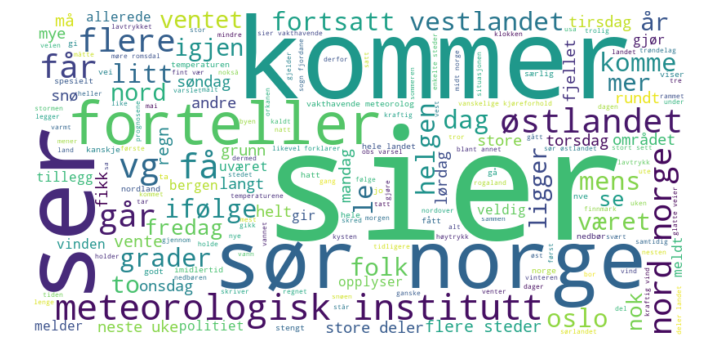

In [150]:
wordcloud = WordCloud(width=800,height=400, background_color="white", stopwords=no_stopwords).generate(texts)
plt.figure( figsize=(12,6) )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

Why do we need to split the data into a training set and test set?

In [50]:
X = df.text
y = df.category
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

## Category distribution in training set

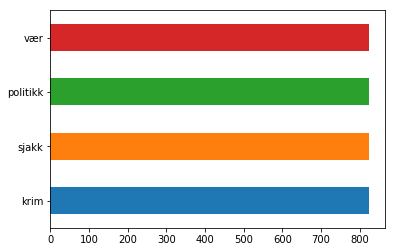

In [52]:
y_train.value_counts().plot.barh();